In [ ]:
! pip install openpiv


     |████████████████████████████████| 22.2MB 1.4MB/s 
     |████████████████████████████████| 163kB 48.0MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 


 Frame A => 
 [[42000 12000 30000 ... 18000 30000 24000]
 [24000 18000 24000 ... 18000 24000 18000]
 [24000 30000 24000 ... 24000 24000 12000]
 ...
 [18000 18000 12000 ... 18000 24000 30000]
 [36000 24000 24000 ... 18000 36000 24000]
 [42000 24000 24000 ... 18000 30000 18000]]


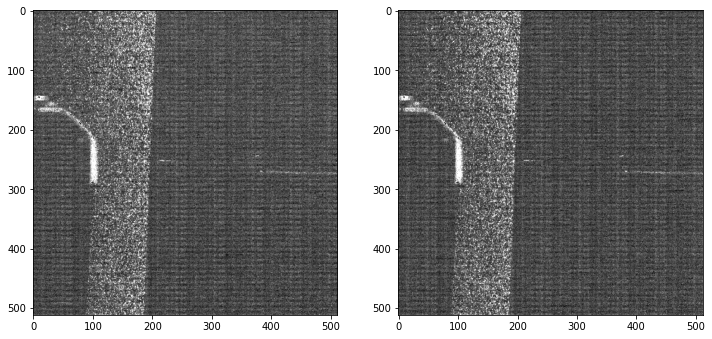

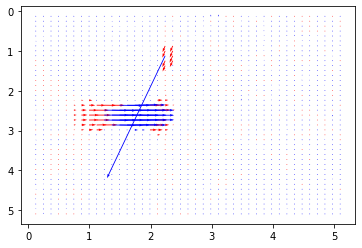

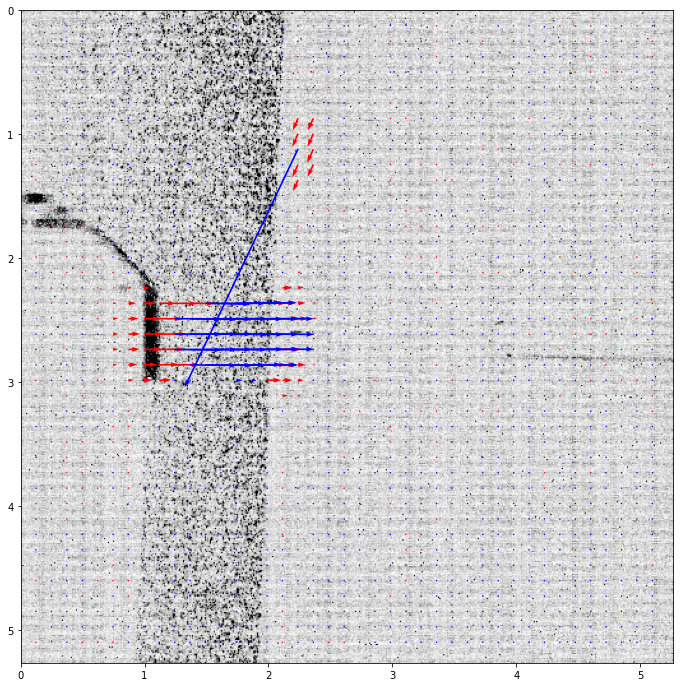

In [ ]:
from openpiv import tools, process, validation, filters, scaling 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import imageio

frame_a  = tools.imread( '/content/B00001.png' )
frame_b  = tools.imread( '/content/B00002.png' )

print(" Frame A => \n",frame_a)


fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)



winsize = 24 # pixels
searchsize = 64  # pixels, search in image B
overlap = 12 # pixels
dt = 0.02 # sec


u0, v0, sig2noise = process.extended_search_area_piv( frame_a.astype(np.int32), frame_b.astype(np.int32), window_size=winsize, overlap=overlap, dt=dt, search_area_size=searchsize, sig2noise_method='peak2peak' )
# OpenPIV function responsible for convultaional analysis of the entire image using a search window


x, y = process.get_coordinates( image_size=frame_a.shape, window_size=winsize, overlap=overlap )
# OpenPIV module that finds the center of the interrogation window


u1, v1, mask = validation.sig2noise_val( u0, v0, sig2noise, threshold = 1.3 )
# OpenPIV module that replaces fake vectors with 0 if below a certain threshhold


u2, v2 = filters.replace_outliers( u1, v1, method='localmean', max_iter=10, kernel_size=2)
# Invalid velocity vectors are replaced with a weighted average of neighbouring elements 
# that are not valid themselves. For the local mean method the kernel size is used to find
# the weighted average. If the surrounding elements are not valid then iterations are used 
# upto a point where variation in the region is below a certain threshold 


x, y, u3, v3 = scaling.uniform(x, y, u2, v2, scaling_factor = 96.52 )



tools.save(x, y, u3, v3, mask, 'exp1_001.txt' )
# saves flow field in an ascii file, masks invalid vectors


tools.display_vector_field('exp1_001.txt', scale=50, width=0.0025)



fig, ax = plt.subplots(figsize=(12,12))
tools.display_vector_field('exp1_001.txt', ax=ax, scaling_factor=96.52, scale=50, width=0.0025, on_img=True, image_name='/content/B00002.png');







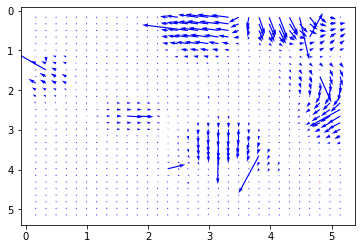

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd9c32c8ef0>)

In [ ]:
from openpiv import tools, process, scaling, validation, filters
import numpy as np

import os

# we can run it from any folder
path = os.path.dirname(os.path.abspath('/content'))


frame_a  = tools.imread( os.path.join(path,'/content/B00001.png'))
frame_b  = tools.imread( os.path.join(path,'/content/B00002.png'))

# converting the images into integeres
frame_a = (frame_a*1024).astype(np.int32)
frame_b = (frame_b*1024).astype(np.int32)

u, v, sig2noise = process.extended_search_area_piv( frame_a, frame_b, \
    window_size=32, overlap=16, dt=0.02, search_area_size=64, sig2noise_method='peak2peak' )
x, y = process.get_coordinates( image_size=frame_a.shape, window_size=32, overlap=16 )
u, v, mask = validation.sig2noise_val( u, v, sig2noise, threshold = 1.3 )
u, v, mask = validation.global_val( u, v, (-1000, 2000), (-1000, 1000) )
# if any velocity vector is outside the above mentioned range those are replaced
# with NaN
u, v = filters.replace_outliers( u, v, method='localmean', max_iter=10, kernel_size=2)
x, y, u, v = scaling.uniform(x, y, u, v, scaling_factor = 96.52 )
tools.save(x, y, u, v, mask, 'test1.vec' )
tools.display_vector_field('test1.vec', scale=75, width=0.0035)